In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from analysis_dependencies import get_wrf_slp
from analysis_dependencies import get_wrf_rh
import datetime
import wrf

In [2]:
# gen_wrf_proj: generate a wrf.WrfProj() object from metadata contained in a WRF file
#
# INPUTS:
#
# wrfHDL: WRF file netCDF4.Dataset() handle
#
# OUTPUTS:
#
# wrfProjObj: wrf.WrfProj() object containing WRF grid's map projection properties.
#
# DEPENDENCIES:
#
# netCDF4.Dataset()
# wrf.WrfProj()
def gen_wrf_proj(wrfHdl):
    from netCDF4 import Dataset
    from wrf import WrfProj
    
    return WrfProj(map_proj=wrfHdl.MAP_PROJ,
                   truelat1=wrfHdl.TRUELAT1,
                   truelat2=wrfHdl.TRUELAT2,
                   moad_cen_lat=wrfHdl.MOAD_CEN_LAT,
                   stand_lon=wrfHdl.STAND_LON,
                   pole_lat=wrfHdl.POLE_LAT,
                   pole_lon=wrfHdl.POLE_LON,
                   dx=wrfHdl.DX,
                   dy=wrfHdl.DY
                  )
# gen_cartopy_proj: generate a cartopy.crs() object from metadata contained in a WRF file
#
# INPUTS:
#
# wrfHDL: WRF file netCDF4.Dataset() handle
#
# OUTPUTS:
#
# crsProjObj: cartopy.crs() object containing WRF grid's map projection properties
#
# DEPENDENCIES:
#
# netCDF4.Dataset()
# cartopy.crs()
#
# NOTES:
# I am following the advice given in this post to explicitly define an Earth SPHERE for
# the projection by defining the cartopy.crs.Globe() with a semimajor_axis and
# semiminor_axis of 6370000. m to match WRF's definition of the Earth as a sphere
# rather than as an ellipsoid.
# https://fabienmaussion.info/2018/01/06/wrf-projection/
# I don't see any significant difference with/without the explicit definition of an
# Earth sphere (lat/lon pass back and forth between either projection and
# cartopy.crs.PlateCarree() with differences on the order of 1.0e-9 degrees), but
# since this is apparently the correct way to do it and it doesn't generate large
# differences, I'm going to go with it in-case my proj <--> PlateCarree tests are
# being done incorrectly. I'm doing no harm with it, as far as I can tell.
def gen_cartopy_proj(wrfHDL):
    from netCDF4 import Dataset
    from cartopy import crs as ccrs
    # WRF is assumed on a Lambert Conformal projection, if it's not the routine
    # will report an error and return None. You can add more projection options
    # as you run into them, but the most common projection is Lambert Conformal
    # so I'm only coding that one here.
    if (wrfHDL.MAP_PROJ == 1) & (wrfHDL.MAP_PROJ_CHAR == "Lambert Conformal"):
        return ccrs.LambertConformal(
                                     central_longitude=wrfHDL.CEN_LON,
                                     central_latitude=wrfHDL.CEN_LAT,
                                     standard_parallels=(wrfHDL.TRUELAT1,wrfHDL.TRUELAT2),
                                     globe=ccrs.Globe(
                                                      semimajor_axis=6370000.,
                                                      semiminor_axis=6370000.
                                                     )
                                    )
    else:
        print('FAILED: UNKNOWN PROJECTION ENCOUNTERED:')
        print('.MAP_PROJ={:d}'.format(wrfHDL.MAP_PROJ))
        print('.MAP_PROJ_CHAR=' + wrfHDL.MAP_PROJ_CHAR)
        return None

In [3]:
unpDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/march2020/R_mu/unperturbed/'
ptdDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/march2020/R_mu/negative/uvTq/ptdi14/'
arcDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/case_archives/march2020/R_mu/negative/uvTq/'
arcPtd = '14'
dtInit = datetime.datetime(2020, 3, 6, 12)

In [4]:
fcstHr = 24
dtFcst = dtInit + datetime.timedelta(hours=fcstHr)
dtInitStr = datetime.datetime.strftime(dtInit,'%Y-%m-%d_%H:00:00')
dtFcstStr = datetime.datetime.strftime(dtFcst,'%Y-%m-%d_%H:00:00')
unpWRFInputFile = arcDir + 'wrfinput_d01_unpi00'
ptdWRFInputFile = arcDir + 'wrfinput_d01_ptdi' + arcPtd
unpFileInit = unpDir + 'wrfout_d01_' + dtInitStr
ptdFileInit = ptdDir + 'wrfout_d01_' + dtInitStr
unpFileFcst = unpDir + 'wrfout_d01_' + dtFcstStr
ptdFileFcst = ptdDir + 'wrfout_d01_' + dtFcstStr
unpHdlInput = Dataset(unpWRFInputFile)
ptdHdlInput = Dataset(ptdWRFInputFile)
unpHdlInit = Dataset(unpFileInit)
ptdHdlInit = Dataset(ptdFileInit)
unpHdlFcst = Dataset(unpFileFcst)
ptdHdlFcst = Dataset(ptdFileFcst)

In [5]:
lat = np.asarray(unpHdlInit.variables['XLAT']).squeeze()
lon = np.asarray(unpHdlInit.variables['XLONG']).squeeze()
fix = np.where(lon < 0.)
lon[fix] = lon[fix] + 360.

unpSLPInput = np.asarray(get_wrf_slp(unpHdlInput)).squeeze()
ptdSLPInput = np.asarray(get_wrf_slp(ptdHdlInput)).squeeze()
unpSLPInit = np.asarray(get_wrf_slp(unpHdlInit)).squeeze()
ptdSLPInit = np.asarray(get_wrf_slp(ptdHdlInit)).squeeze()
unpSLPFcst = np.asarray(get_wrf_slp(unpHdlFcst)).squeeze()
ptdSLPFcst = np.asarray(get_wrf_slp(ptdHdlFcst)).squeeze()

unpRHInput = np.asarray(get_wrf_rh(unpHdlInput)).squeeze()
ptdRHInput = np.asarray(get_wrf_rh(ptdHdlInput)).squeeze()
unpRHInit = np.asarray(get_wrf_rh(unpHdlInit)).squeeze()
ptdRHInit = np.asarray(get_wrf_rh(ptdHdlInit)).squeeze()

unpPInput = np.asarray(wrf.getvar(unpHdlInput,'p')).squeeze()
ptdPInput = np.asarray(wrf.getvar(ptdHdlInput,'p')).squeeze()
unpPInit = np.asarray(wrf.getvar(unpHdlInit,'p')).squeeze()
ptdPInit = np.asarray(wrf.getvar(ptdHdlInit,'p')).squeeze()

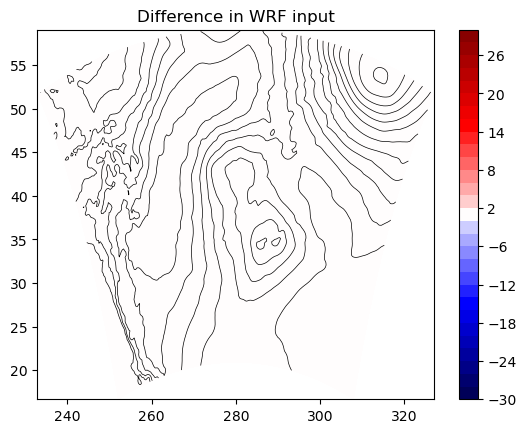

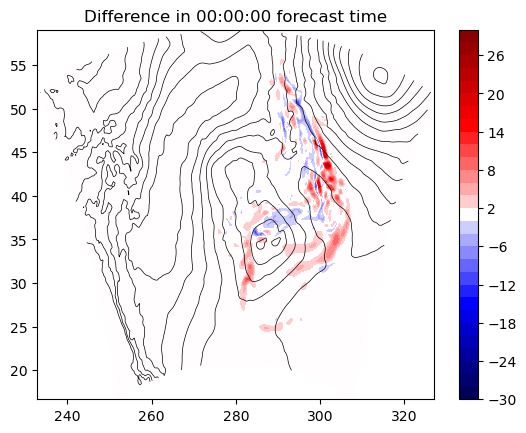

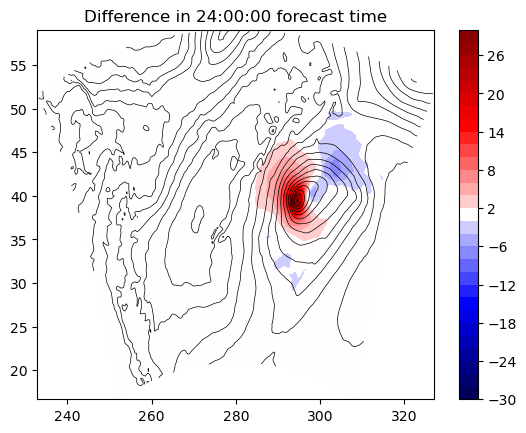

In [6]:
shdrng = np.arange(-30.,30.1,2.)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False

shd=plt.contourf(lon,lat,ptdSLPInput-unpSLPInput,shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPInput,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('Difference in WRF input')
plt.show()

shd=plt.contourf(lon,lat,ptdSLPInit-unpSLPInit,shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPInit,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('Difference in 00:00:00 forecast time')
plt.show()

shd=plt.contourf(lon,lat,ptdSLPFcst-unpSLPFcst,shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPFcst,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('Difference in ' + str(fcstHr) + ':00:00 forecast time')
plt.show()

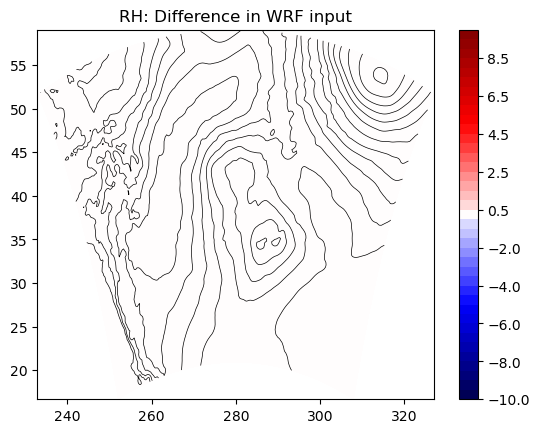

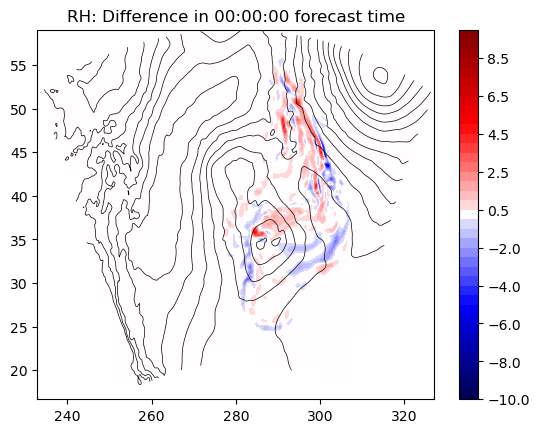

In [7]:
k = 0

shdrng = np.arange(-10.,10.1,0.5)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False

shd=plt.contourf(lon,lat,ptdRHInput[k,:,:].squeeze()-unpRHInput[k,:,:].squeeze(),shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPInit,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('RH: Difference in WRF input')
plt.show()

shd=plt.contourf(lon,lat,ptdRHInit[k,:,:].squeeze()-unpRHInit[k,:,:].squeeze(),shdrng[mask],cmap='seismic')
plt.contour(lon,lat,unpSLPInit,np.arange(960.,1042.1,4.),colors='black',linewidths=0.5)
plt.colorbar(mappable=shd)
plt.title('RH: Difference in 00:00:00 forecast time')
plt.show()

In [25]:
proj=gen_wrf_proj(unpHdlInit)
xbeg=wrf.CoordPair(lat=30.,lon=280.)
xend=wrf.CoordPair(lat=45.,lon=310.)
unpX = wrf.vertcross(field3d=unpRHInit,
                     vert=unpPInit,
                     levels=np.arange(10000.,102000.1,5000.),
                     missing=np.nan,
                     wrfin=unpHdlInit,
                     stagger='m',
                     projection=proj,
                     start_point=xbeg,
                     end_point=xend,
                     latlon=True
                     )

/home/bhoover/miniconda3/envs/UWAOS_WRF_QOIP/lib/python3.11/site-packages/wrf/metadecorators.py:1109: UserWarning: 'latlon' is set to True, but 'field3d' is not of type xarray.DataArray and contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' is "


In [30]:
rh=get_wrf_rh(unpHdlInit)
rh.assign_coords({"lon": unpHdlInit.variables['XLONG']})
unpX = wrf.vertcross(field3d=get_wrf_rh(unpHdlInit),
                     vert=wrf.getvar(unpHdlInit,'p'),
                     levels=np.arange(10000.,102000.1,5000.),
                     missing=np.nan,
                     wrfin=unpHdlInit,
                     stagger='m',
                     projection=proj,
                     start_point=xbeg,
                     end_point=xend,
                     latlon=True
                     )

ValueError: dimensions () must have the same length as the number of data dimensions, ndim=3

In [39]:
p=wrf.getvar(unpHdlInit,'p')
p

<xarray.DataArray 'pressure' (bottom_top: 40, south_north: 143, west_east: 209)>
array([[[100179.3874834 , 100180.88157363, 100181.8647126 , ...,
         100787.91689243, 100783.55661171, 100781.50734606],
        [100179.19491941, 100179.84917319, 100178.60432767, ...,
         100796.69498143, 100793.09066385, 100790.77543905],
        [100180.86609838, 100179.35138178, 100178.20225372, ...,
         100809.54740861, 100803.69979982, 100800.30965163],
        ...,
        [ 92298.39918803,  86682.56571562,  83260.52249434, ...,
          98079.32297848,  98164.60198171,  98245.79378037],
        [ 90554.14944585,  86124.9331789 ,  82872.47807687, ...,
          98064.08538163,  98145.75726016,  98224.79486624],
        [ 91135.10817182,  87849.50723409,  84400.69206134, ...,
          98045.98663565,  98126.05713436,  98202.15858402]],

       [[ 97747.53249615,  97748.32560529,  97749.10600236, ...,
          98337.5120731 ,  98335.39479136,  98333.31132337],
        [ 97747.89249899,  97747.097758  ,  97746.20621087, ...,
          98345.95173632,  98343.22638299,  98341.86756389],
        [ 97749.35769528,  97747.11393844,  97745.63263339, ...,
          98358.14724583,  98353.45430811,  98349.57637815],
...
        [  8313.4051025 ,   8100.74662395,   7971.114066  , ...,
           8530.60837491,   8533.45283979,   8536.2686505 ],
        [  8247.28923925,   8079.54736165,   7956.3481347 , ...,
           8530.04189593,   8532.81054417,   8535.55277053],
        [  8269.36280412,   8144.9832639 ,   8014.3437917 , ...,
           8529.38900221,   8532.15119843,   8534.78342175]],

       [[  6201.96718205,   6202.03114745,   6202.11847134, ...,
           6210.37502374,   6210.34266856,   6210.2955376 ],
        [  6201.92452318,   6201.91909184,   6201.98541876, ...,
           6210.54118532,   6210.52957037,   6210.51261597],
        [  6201.90019566,   6201.87543736,   6201.90752059, ...,
           6210.73113878,   6210.68763886,   6210.67589037],
        ...,
        [  6104.46699348,   6033.58733701,   5990.3777414 , ...,
           6176.87026569,   6177.81607928,   6178.75409119],
        [  6082.42720068,   6026.51141911,   5985.45280063, ...,
           6176.6785179 ,   6177.60306842,   6178.51684876],
        [  6089.77902814,   6048.32653951,   6004.77688464, ...,
           6176.46490363,   6177.38412313,   6178.25641079]]])
Coordinates:
    XLONG    (south_north, west_east) float64 -108.0 -107.7 ... -33.25 -32.87
    XLAT     (south_north, west_east) float64 16.66 16.74 16.81 ... 51.76 51.62
    XTIME    float64 0.0
    Time     datetime64[ns] 2020-03-06T12:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:      105
    MemoryOrder:    XYZ
    description:    pressure
    units:          Pa
    stagger:        
    coordinates:    XLONG XLAT XTIME
    projection:     LambertConformal(stand_lon=-80.0, moad_cen_lat=40.0000076...
    _FillValue:     1e+20
    missing_value:  1e+20

In [74]:
dim_dict={
          rh.dims[0] : p.dims[0],
          rh.dims[1] : p.dims[1],
          rh.dims[2] : p.dims[2]
         }
rh=rh.rename(dim_dict)
rh=rh.assign_coords(p.coords)
unpX = wrf.vertcross(field3d=rh,
                     vert=wrf.getvar(unpHdlInit,'p'),
                     levels=np.arange(10000.,102000.1,5000.),
                     missing=np.nan,
                     wrfin=unpHdlInit,
                     stagger='m',
                     projection=proj,
                     start_point=xbeg,
                     end_point=xend,
                     latlon=True
                     )
pointLats=[]
pointLons=[]
for point in unpX.xy_loc.values:
    pointLatLonStr = point.latlon_str().split(', ')
    pointLats.append(float(pointLatLonStr[0]))
    pointLons.append(float(pointLatLonStr[1]))

In [71]:
unpX.xy_loc.values[0].latlon_str().split(', ')

['29.9160', '-80.0000']

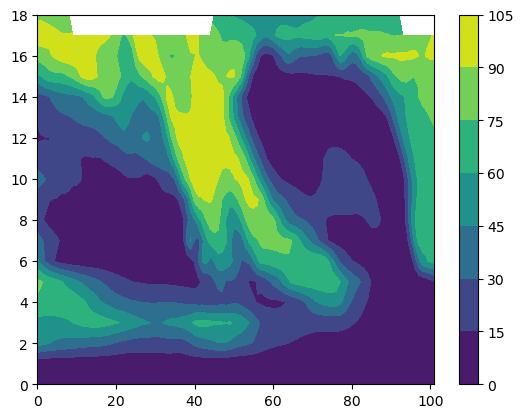

In [75]:
plt.contourf(unpX)
plt.colorbar()
plt.show()

In [79]:
import cartopy
from cartopy import crs as ccrs
from cartopy import feature as cfeature

In [133]:
dat_proj = gen_cartopy_proj(unpHdlInit)
plot_proj = ccrs.PlateCarree()

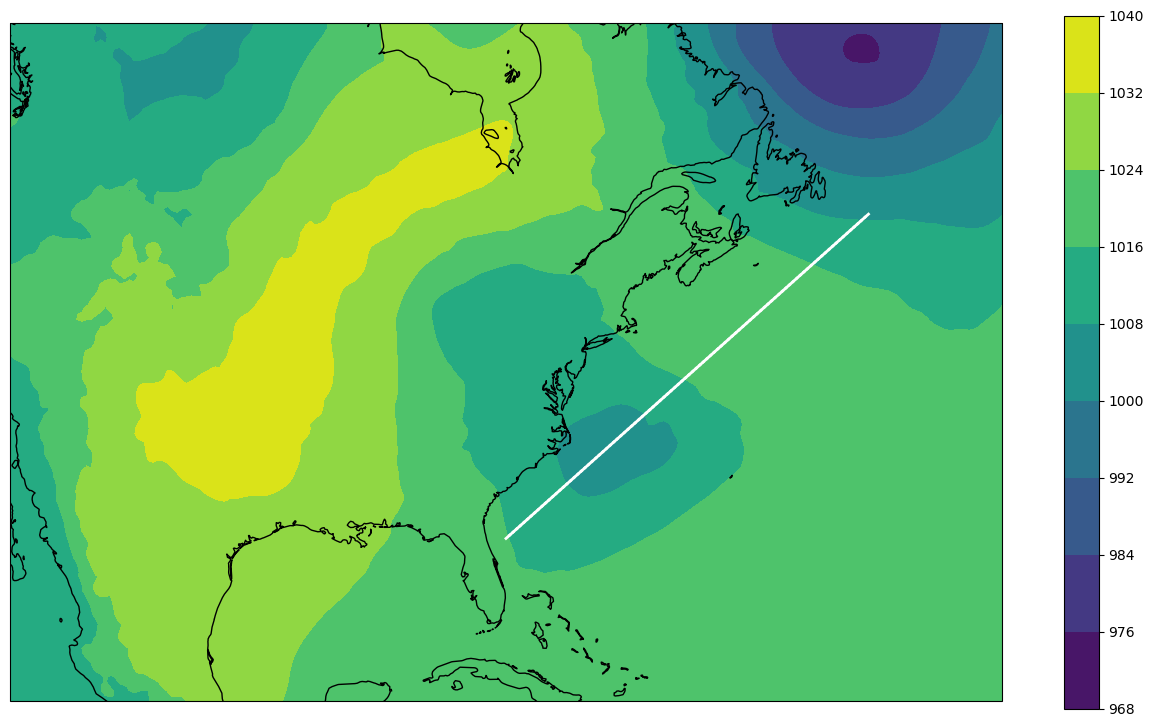

In [140]:
fig=plt.figure(figsize=(16,9))
ax=plt.axes(projection=dat_proj)
shd=ax.contourf(lon,lat,unpSLPInit,transform=ccrs.PlateCarree(),zorder=0)
fig.colorbar(ax=ax,mappable=shd)
for i in range(len(pointLons)-1):
    lin=ax.plot((pointLons[i],pointLons[i+1]),(pointLats[i],pointLats[i+1]),color='w',linewidth=2.,transform=plot_proj)
ax.add_feature(cfeature.COASTLINE,zorder=1)
plt.show()


In [129]:
print(pointLons[0],pointLons[-1])

-80.0 -50.1154


In [ ]:
# Projection tests below

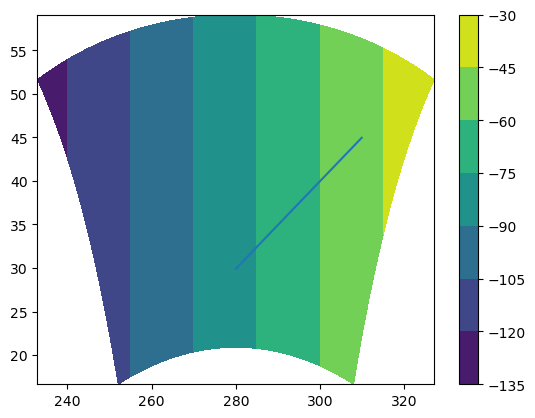

In [132]:
plt.contourf(lon,lat,lon-360)
plt.plot([pointLons[0]+360,pointLons[-1]+360],[pointLats[0],pointLats[-1]])
plt.colorbar()
plt.show()

In [73]:
bad_proj = ccrs.LambertConformal(
                                 central_longitude=unpHdlInit.CEN_LON,
                                 central_latitude=unpHdlInit.CEN_LAT,
                                 standard_parallels=(unpHdlInit.TRUELAT1,unpHdlInit.TRUELAT2),
                                 globe=None
                       ) # The Earth is now an ellipsoid

In [101]:
good_proj = ccrs.LambertConformal(
                                 central_longitude=unpHdlInit.CEN_LON,
                                 central_latitude=unpHdlInit.CEN_LAT,
                                 standard_parallels=(unpHdlInit.TRUELAT1,unpHdlInit.TRUELAT2),
                                 globe=ccrs.Globe(semimajor_axis=6370000.,semiminor_axis=6370000.)
                       ) # The Earth is now a sphere, as per WRF

In [102]:
plot_proj = ccrs.PlateCarree(central_longitude=unpHdlInit.CEN_LON)

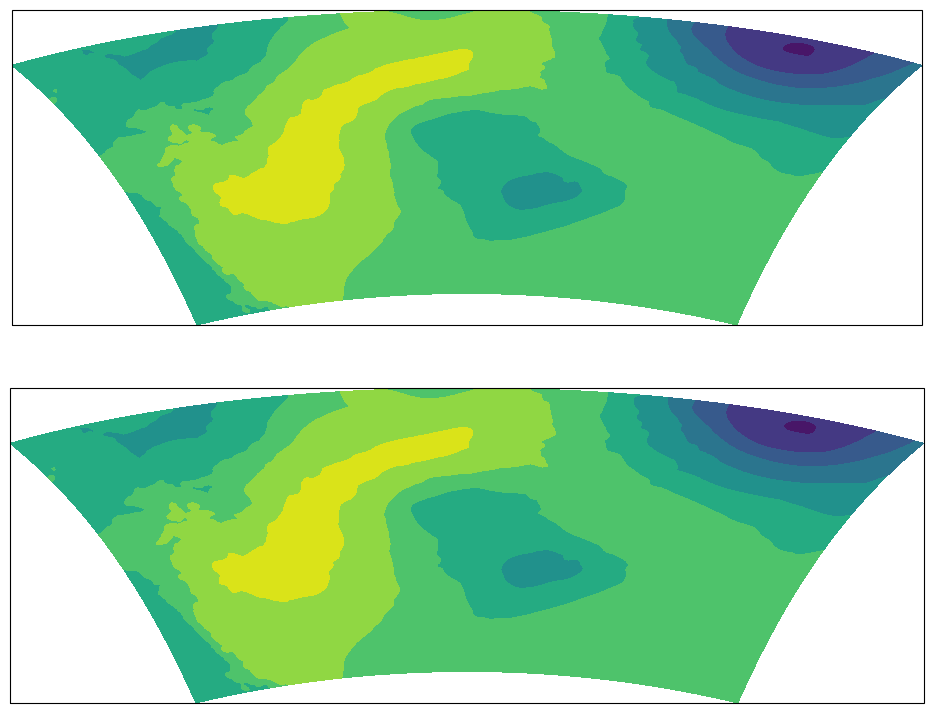

In [110]:
fig, (ax1, ax2) = plt.subplots(nrows=2, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,9))
ax=ax1
ax.contourf(lon,lat,unpSLPInit,transform=bad_proj)
ax=ax2
ax.contourf(lon,lat,unpSLPInit,transform=good_proj)

In [112]:
plot_proj.transform_point(lon[0,0],lat[0,0],bad_proj)

(0.0029970124523226063, 40.000159928036325)

In [113]:
plot_proj.transform_point(lon[0,0],lat[0,0],good_proj)

(0.0030051822467239086, 40.000159741509066)

In [114]:
bad_pts = plot_proj.transform_points(src_crs=bad_proj,x=lon,y=lat)
bad_x=bad_pts[:,:,0].squeeze()
bad_y=bad_pts[:,:,1].squeeze()
good_pts = plot_proj.transform_points(src_crs=good_proj,x=lon,y=lat)
good_x=good_pts[:,:,0].squeeze()
good_y=good_pts[:,:,1].squeeze()

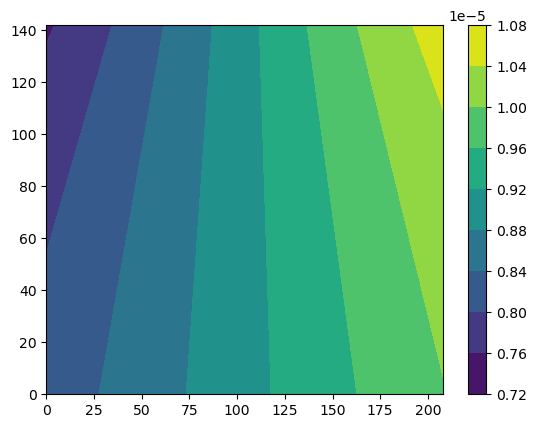

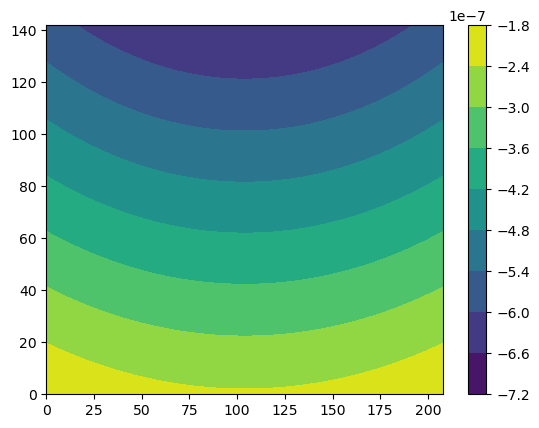

In [116]:
plt.contourf(good_x-bad_x)
plt.colorbar()
plt.show()

plt.contourf(good_y-bad_y)
plt.colorbar()
plt.show()

In [123]:
bad_ll=bad_proj.transform_points(src_crs=plot_proj,x=bad_x,y=bad_y)
bad_lon=bad_ll[:,:,0].squeeze()
bad_lat=bad_ll[:,:,1].squeeze()
good_ll=good_proj.transform_points(src_crs=plot_proj,x=good_x,y=good_y)
good_lon=good_ll[:,:,0].squeeze()
good_lat=good_ll[:,:,1].squeeze()

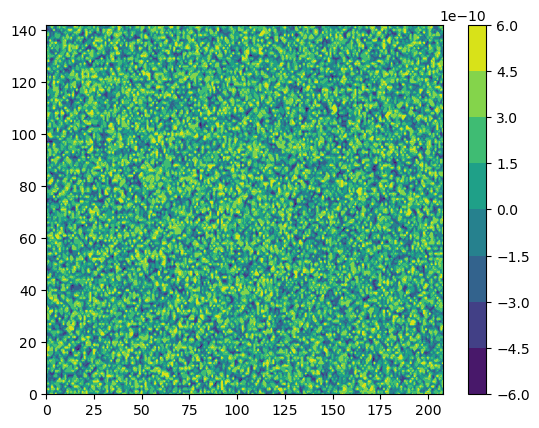

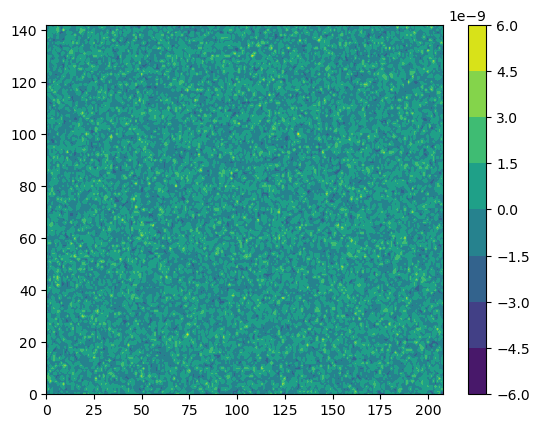

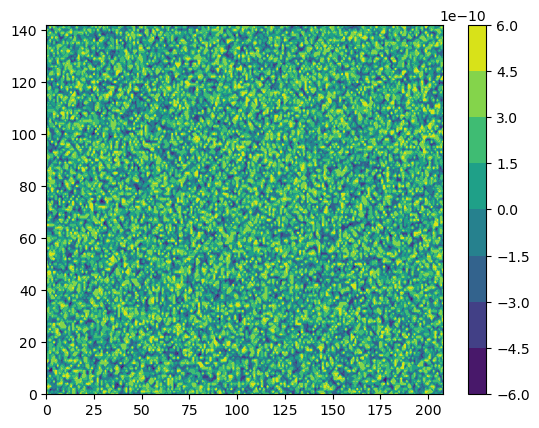

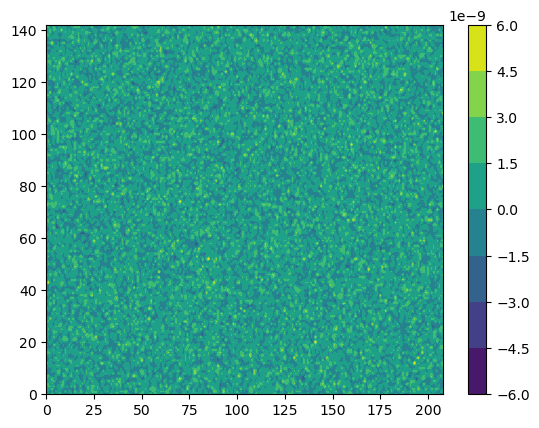

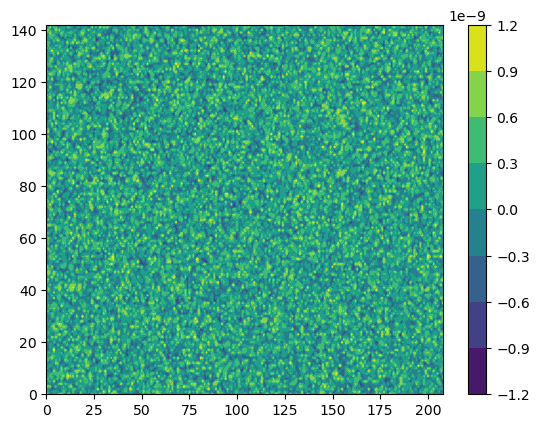

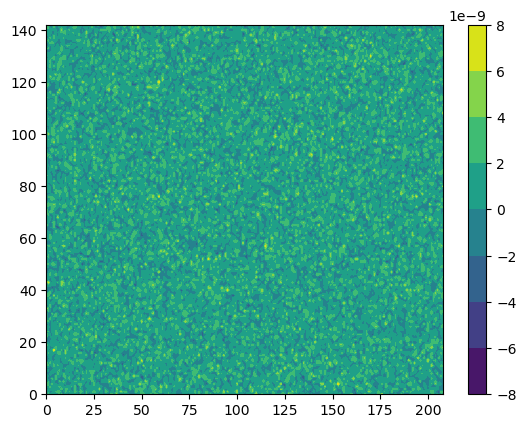

In [126]:
plt.contourf(bad_lon-lon)
plt.colorbar()
plt.show()

plt.contourf(bad_lat-lat)
plt.colorbar()
plt.show()

plt.contourf(good_lon-lon)
plt.colorbar()
plt.show()

plt.contourf(good_lat-lat)
plt.colorbar()
plt.show()

plt.contourf(good_lon-bad_lon)
plt.colorbar()
plt.show()

plt.contourf(good_lat-bad_lat)
plt.colorbar()
plt.show()